# Understanding Probabilistic Programming Through the Monty Hall Problem
![image](../pics/Monty_open_door.svg.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zolizoli/probprogMonty/blob/main/monty_hall.ipynb)

### Introduction

The [Monty Hall Problem (MHP)](https://en.wikipedia.org/wiki/Monty_Hall_problem) is one of probability theory's most fascinating puzzles - not just for its counter-intuitive solution, but for what it reveals about human reasoning. As Steven Pinker notes, even brilliant mathematicians like Paul Erdős initially rejected the correct solution, and many people persist in their incorrect intuitions even after seeing simulations or playing for money.
This resistance to the correct solution makes the MHP a perfect vehicle for exploring Probabilistic Programming Languages (PPLs). These languages help bridge the gap between our intuitive causal reasoning and formal probabilistic thinking by allowing us to:

+ Explicitly model the causal structure of problems
+ Reason about uncertainty in a principled way
+ Update beliefs based on evidence
+ Separate the model specification from inference

In this notebook, we'll explore both why humans find the MHP so difficult and how PPLs can help us think more clearly about such problems. We'll progress through:

1. Traditional simulation approaches
2. Common reasoning pitfalls
3. Probabilistic programming implementations
4. How PPLs make the solution more transparent

Testing this test to test the test.


### Setup and Imports

In [2]:
import random
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import matplotlib.pyplot as plt

# Set device for PyTorch/Pyro
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Traditional Simulation Approach
First, let's implement the Monty Hall Problem using traditional Python:

In [3]:
def simulate_monty_hall(num_trials=10000, switch=True):
    """
    Simulate the Monty Hall problem using traditional programming

    Args:
        num_trials (int): Number of games to simulate
        switch (bool): Whether the player switches their choice

    Returns:
        float: Win percentage
    """
    wins = 0

    for _ in range(num_trials):
        # Initialize doors (0 = goat, 1 = car)
        doors = [0, 0, 1]
        random.shuffle(doors)

        # Initial choice
        initial_choice = random.randint(0, 2)

        # Host reveals a goat
        possible_reveals = [
            i for i in range(3) if i != initial_choice and doors[i] == 0
        ]
        revealed_door = random.choice(possible_reveals)

        if switch:
            final_choice = [
                i for i in range(3) if i != initial_choice and i != revealed_door
            ][0]
        else:
            final_choice = initial_choice

        if doors[final_choice] == 1:
            wins += 1

    return wins / num_trials

## Part 2: Probabilistic Programming Implementation

Now let's implement the same problem using Pyro, highlighting the key differences in approach:

In [4]:
def host_conditional_probs(prize_door: int, contestant_door: int) -> list:
    """
    Calculate conditional probabilities for host's door choice

    Args:
        prize_door (int): Door with the prize
        contestant_door (int): Door chosen by contestant

    Returns:
        list: Probability distribution for host's choice
    """
    if prize_door == contestant_door:
        probs = [0.5, 0.5, 0.5]
        probs[contestant_door] = 0.0
        return probs

    probs = [1.0, 1.0, 1.0]
    probs[contestant_door] = 0.0
    probs[prize_door] = 0.0
    return probs


def simulate_game_pyro():
    """
    Simulate one complete Monty Hall game using probabilistic programming
    """
    # prior probabilities
    probs_loc_prize = torch.tensor([1 / 3, 1 / 3, 1 / 3], device=device)

    # prize location
    prize_door = pyro.sample("prize_door", dist.Categorical(probs_loc_prize))

    # contestant's choice
    contestant_door = pyro.sample("contestant_door", dist.Categorical(probs_loc_prize))

    host_probs = torch.tensor(
        host_conditional_probs(int(prize_door.cpu()), int(contestant_door.cpu())),
        device=device,
    )
    host_door = pyro.sample("host_door", dist.Categorical(host_probs))

    doors = set(range(3))
    switch_door = doors - {int(contestant_door.cpu()), int(host_door.cpu())}
    switch_door = next(iter(switch_door))

    stay_wins = (contestant_door == prize_door).cpu().item()
    switch_wins = switch_door == int(prize_door.cpu())

    return {
        "stay_wins": stay_wins,
        "switch_wins": switch_wins,
        "prize_door": int(prize_door.cpu()),
        "initial_door": int(contestant_door.cpu()),
        "host_door": int(host_door.cpu()),
        "final_door_if_switch": switch_door,
    }

## Part 3: Running Simulations and Visualization

Let's compare the results from both approaches:

In [5]:
# Traditional simulation
np.random.seed(42)
random.seed(42)

stay_wins = simulate_monty_hall(num_trials=10000, switch=False)
switch_wins = simulate_monty_hall(num_trials=10000, switch=True)

print(f"Traditional Simulation Results:")
print(f"Stay win rate: {stay_wins:.3f}")
print(f"Switch win rate: {switch_wins:.3f}")

# Probabilistic programming simulation
results = []
n_games = 10000

for game in range(n_games):
    pyro.clear_param_store()
    outcome = simulate_game_pyro()
    results.append(outcome)

df = pd.DataFrame(results)
print(f"\nProbabilistic Programming Results:")
print(f"Stay win rate: {df['stay_wins'].mean():.3f}")
print(f"Switch win rate: {df['switch_wins'].mean():.3f}")

Traditional Simulation Results:
Stay win rate: 0.331
Switch win rate: 0.665

Probabilistic Programming Results:
Stay win rate: 0.336
Switch win rate: 0.664


### Key Differences and Advantages of PPL Approach

1. Explicit Probability Modeling: The PPL implementation directly models probability distributions and dependencies, making the underlying probabilistic structure more clear.
2. Inference Capabilities: While not shown in this basic example, PPLs allow us to perform both forward simulation and backward inference, enabling us to:
    + Learn from observed data
    + Update beliefs based on evidence
    + Infer unobserved variables
3. Flexibility: The probabilistic programming approach makes it easier to modify and extend the model, such as:
    + Adding noise to player decisions
    + Modeling learning effects
    + Incorporating prior knowledge
    + Handling missing data
4. Declarative Nature: The PPL code focuses on describing the probabilistic model rather than the procedural details of the simulation.

## Part 4: Repeated Experiments and Learning
One of the most interesting aspects of the Monty Hall problem is studying how people learn (or fail to learn) the optimal strategy through repeated play. We can model this using probabilistic programming:


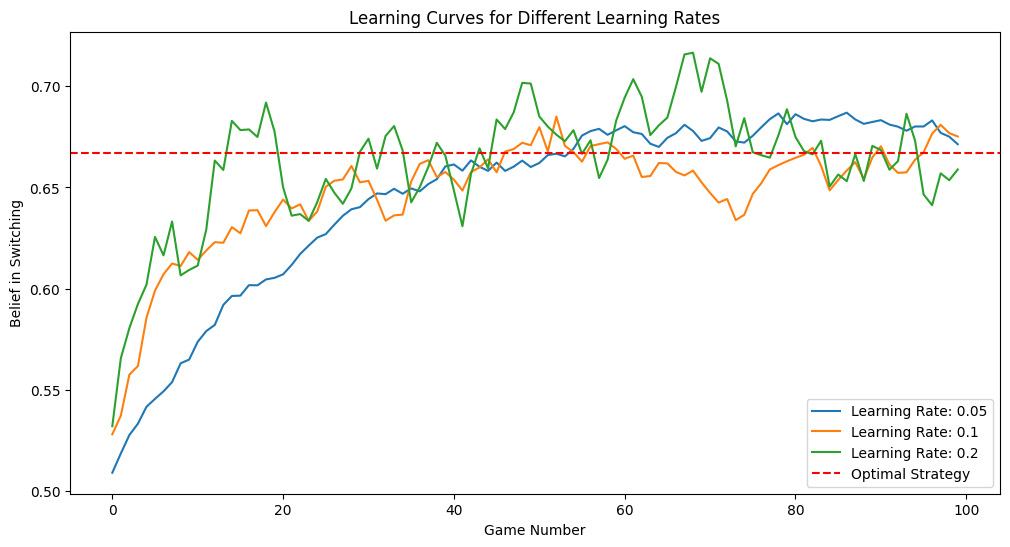

In [7]:
def simulate_learning_player(n_games=100, learning_rate=0.1):
    """
    Simulate a player who learns from experience

    Args:
        n_games (int): Number of games to play
        learning_rate (float): How quickly the player updates their beliefs

    Returns:
        dict: Game outcomes and belief updates
    """
    # Initialize belief about switch being optimal
    switch_belief = 0.5  # Start with no preference
    outcomes = []
    beliefs = [switch_belief]

    for game in range(n_games):
        # Make decision based on current belief
        will_switch = pyro.sample(
            f"decision_{game}", dist.Bernoulli(torch.tensor(switch_belief))
        ).item()

        # Play the game
        pyro.clear_param_store()
        game_result = simulate_game_pyro()

        # Record outcome
        won = game_result["switch_wins"] if will_switch else game_result["stay_wins"]

        # Update belief using simple reinforcement learning
        if won:
            switch_belief = (
                switch_belief + learning_rate * (1 - switch_belief)
                if will_switch
                else switch_belief - learning_rate * switch_belief
            )
        else:
            switch_belief = (
                switch_belief - learning_rate * switch_belief
                if will_switch
                else switch_belief + learning_rate * (1 - switch_belief)
            )

        outcomes.append(
            {
                "game": game,
                "switch_decision": will_switch,
                "won": won,
                "switch_belief": switch_belief,
            }
        )
        beliefs.append(switch_belief)

    return outcomes, beliefs


# Simulate multiple players with different learning rates
def simulate_population(n_players=50, n_games=100, learning_rates=[0.05, 0.1, 0.2]):
    """
    Simulate a population of players with different learning rates
    """
    all_results = []

    for lr in learning_rates:
        for player in range(n_players):
            outcomes, beliefs = simulate_learning_player(n_games, lr)
            player_df = pd.DataFrame(outcomes)
            player_df["player"] = player
            player_df["learning_rate"] = lr
            all_results.append(player_df)

    return pd.concat(all_results, ignore_index=True)


# Run population simulation
population_results = simulate_population()

# Visualize learning curves by learning rate
plt.figure(figsize=(12, 6))
for lr in population_results["learning_rate"].unique():
    lr_data = population_results[population_results["learning_rate"] == lr]
    avg_belief = lr_data.groupby("game")["switch_belief"].mean()
    plt.plot(avg_belief.index, avg_belief.values, label=f"Learning Rate: {lr}")

plt.axhline(y=0.667, color="r", linestyle="--", label="Optimal Strategy")
plt.xlabel("Game Number")
plt.ylabel("Belief in Switching")
plt.title("Learning Curves for Different Learning Rates")
plt.legend()
plt.show()

This implementation allows us to explore several interesting aspects of learning:

1. Individual Differences: By varying the learning rate, we can model different types of learners:
    + Slow learners (low learning rate) who take many games to adjust their strategy
    + Fast learners (high learning rate) who quickly adapt but might be more volatile
    + Non-learners (learning rate ≈ 0) who stick to their initial strategy
2. Belief Dynamics: We can observe how beliefs evolve over time:
    + Initial uncertainty (belief = 0.5)
    + Gradual convergence toward optimal strategy
    + Potential local optima or incorrect beliefs
3. Population Effects: By simulating multiple players, we can study:
    + Distribution of final strategies
    + Time to learn optimal strategy
    + Persistence of suboptimal beliefs
4. Model Extensions: This basic model can be extended to include:
    + More sophisticated learning rules
    + Memory effects
    + Social learning
    + Risk aversion
    + Decision noise

The probabilistic programming approach makes it particularly easy to modify and extend this model. For example, we could:
+ Add prior knowledge about optimal strategies
+ Model explicit reasoning about probability
+ Include confidence in beliefs
+ Incorporate forget rates

## Conclusion
While both approaches correctly demonstrate the famous Monty Hall paradox, the probabilistic programming implementation provides a more flexible and extensible framework for modeling complex probabilistic systems. This becomes particularly valuable when dealing with real-world applications where we need to reason about uncertainty, learn from data, and update our beliefs based on evidence.

# Part Five - Backward Simulation

After implementing forward simulation and learning models, we can now use backward simulation to infer how players reason about the Monty Hall problem. Our model considers two key aspects of player reasoning:

+ Host Knowledge: How much weight players give to the fact that the host knows the prize location
+ Probability Updating: How effectively players update their beliefs after seeing the host's choice

We simulate three types of players:

+ Naive players who rarely switch (ignoring host knowledge)
+ Learning players who gradually improve their strategy
+ Optimal players who understand the advantage of switching

The model infers these cognitive parameters from observed behavior, revealing how different player types process information differently. For example, naive players typically show low host knowledge scores, indicating they treat the host's door choice as random rather than strategic. Optimal players, in contrast, demonstrate high scores in both parameters, reflecting their understanding of the game's probabilistic structure.
This backward simulation transforms the Monty Hall problem from a puzzle about probability into a window into human reasoning, helping us understand not just what decisions people make, but why they make them.


Analyzing naive player...
Step 0: Loss = 20.284
Step 200: Loss = 20.271
Step 400: Loss = 24.292
Step 600: Loss = 24.081
Step 800: Loss = 24.095
Inferred parameters:
Host knowledge: 0.381
Probability updating: 0.374

Analyzing learning player...
Step 0: Loss = 38.909
Step 200: Loss = 34.952
Step 400: Loss = 35.433
Step 600: Loss = 35.353
Step 800: Loss = 54.157
Inferred parameters:
Host knowledge: 0.762
Probability updating: 0.772

Analyzing optimal player...
Step 0: Loss = 48.360
Step 200: Loss = 50.019
Step 400: Loss = 23.171
Step 600: Loss = 26.214
Step 800: Loss = 21.764
Inferred parameters:
Host knowledge: 0.911
Probability updating: 0.909


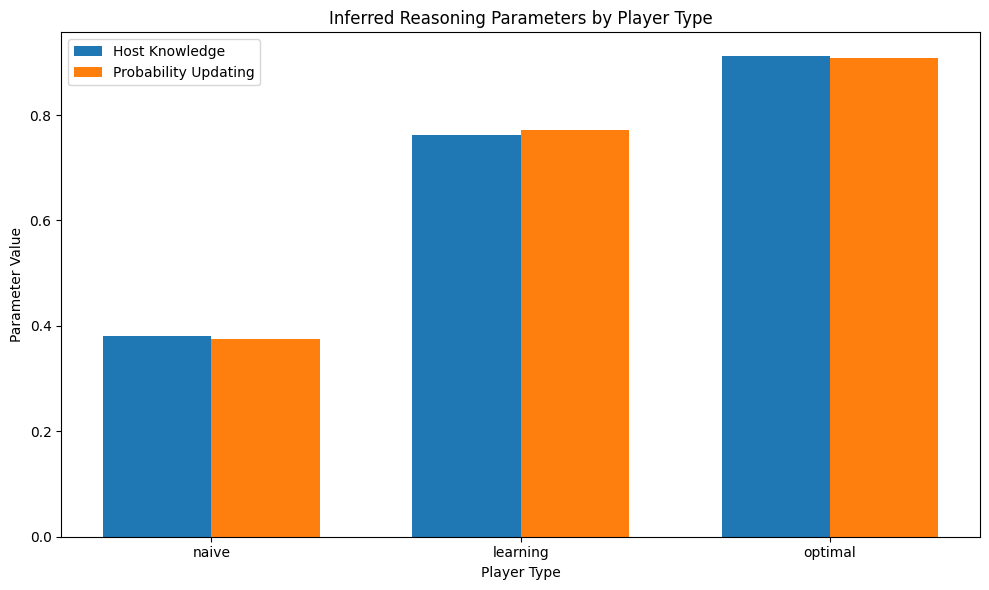

{'naive': {'host_knowledge': 0.380582653447754,
  'prob_updating': 0.3743643224127298},
 'learning': {'host_knowledge': 0.7615586116429744,
  'prob_updating': 0.771510125217807},
 'optimal': {'host_knowledge': 0.9113977038047685,
  'prob_updating': 0.9085472283541115}}

In [10]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

def create_player_data(strategy_type, n_games=50):
    """Generate synthetic player data for different strategy types."""
    switch_probs = {
        'naive': 0.1,      # Rarely switches
        'learning': 0.3,   # Starts cautious, learns over time
        'optimal': 0.9     # Usually switches
    }
    
    base_prob = switch_probs[strategy_type]
    learning_rate = 0.01 if strategy_type == 'learning' else 0
    
    decisions = []
    for game in range(n_games):
        switch_prob = min(base_prob + (game * learning_rate), 1.0) if strategy_type == 'learning' else base_prob
        switched = float(np.random.rand() < switch_prob)
        decisions.append(switched)
    
    return torch.tensor(decisions)

def model(data):
    """Probabilistic model for player reasoning."""
    host_knowledge = pyro.sample("host_knowledge", dist.Beta(2, 2))
    prob_updating = pyro.sample("prob_updating", dist.Beta(2, 2))
    
    switch_prob = torch.clamp(host_knowledge * prob_updating, 0.0, 1.0)
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Bernoulli(switch_prob.expand(len(data))), obs=data)

def guide(data):
    """Variational guide for inference."""
    alpha_h = pyro.param('alpha_h', torch.tensor(2.0), constraint=dist.constraints.positive)
    beta_h = pyro.param('beta_h', torch.tensor(2.0), constraint=dist.constraints.positive)
    alpha_p = pyro.param('alpha_p', torch.tensor(2.0), constraint=dist.constraints.positive)
    beta_p = pyro.param('beta_p', torch.tensor(2.0), constraint=dist.constraints.positive)
    
    host_knowledge = pyro.sample('host_knowledge', dist.Beta(alpha_h, beta_h))
    prob_updating = pyro.sample('prob_updating', dist.Beta(alpha_p, beta_p))

def infer_parameters(data, num_iterations=1000):
    """Perform variational inference on player data."""
    pyro.clear_param_store()
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    for step in range(num_iterations):
        loss = svi.step(data)
        if step % 200 == 0:
            print(f"Step {step}: Loss = {loss:.3f}")
    
    alpha_h = pyro.param("alpha_h").item()
    beta_h = pyro.param("beta_h").item()
    alpha_p = pyro.param("alpha_p").item()
    beta_p = pyro.param("beta_p").item()
    
    return {
        "host_knowledge": alpha_h / (alpha_h + beta_h),
        "prob_updating": alpha_p / (alpha_p + beta_p)
    }

def plot_learning_curves(results):
    """Plot learning curves for different player types."""
    plt.figure(figsize=(10, 6))
    x = np.arange(len(results))
    width = 0.35
    
    host_values = [results[pt]['host_knowledge'] for pt in results]
    prob_values = [results[pt]['prob_updating'] for pt in results]
    
    plt.bar(x - width/2, host_values, width, label='Host Knowledge')
    plt.bar(x + width/2, prob_values, width, label='Probability Updating')
    
    plt.xlabel('Player Type')
    plt.ylabel('Parameter Value')
    plt.title('Inferred Reasoning Parameters by Player Type')
    plt.xticks(x, list(results.keys()))
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_players():
    """Analyze different player types and visualize results."""
    player_types = ['naive', 'learning', 'optimal']
    results = {}
    
    for player_type in player_types:
        print(f"\nAnalyzing {player_type} player...")
        data = create_player_data(player_type)
        results[player_type] = infer_parameters(data)
        
        print(f"Inferred parameters:")
        print(f"Host knowledge: {results[player_type]['host_knowledge']:.3f}")
        print(f"Probability updating: {results[player_type]['prob_updating']:.3f}")
    
    plot_learning_curves(results)
    return results


analyze_players()

## Sources
+ [Why You Should Always Switch: The Monty Hall Problem (Finally) Explained](https://behavioralscientist.org/steven-pinker-rationality-why-you-should-always-switch-the-monty-hall-problem-finally-explained/)
+ [Why Humans Fail in Solving the Monty Hall Dilemma: A Systematic Review](https://pmc.ncbi.nlm.nih.gov/articles/PMC6194549/)